## Seattle Airbnb Open Data Analysis (Part 2)

This report is split into multiple notebooks as follows.
<br>
###### Part 1 ([link](./Seattle Airbnb Open Data - Part 1.ipynb))
 1 . Business Understanding<br>
 2 . Data Understanding
###### Part 2 (This notebook)
 3 . Data Preparation<br>
###### Part 3 ([link](./Seattle Airbnb Open Data - Part 3.ipynb))
 4 . Data Modeling<br>
 5 . Results Evaluation<br>
###### Blog Post
 6 . Deployment (to be linked from README.md)<br>

Before continuing to data preparation, we check business questions we will answer again.
###### Q1: What are the busiest times of the year to visit Seattle? By how much do prices spike?
###### Q2: Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?
###### Q3: How well can we predict a price of Seattle Airbnb listings? What aspects correlate well to price?

### 3. Data Preparation
Let's import necessary libraries again with some additions.

In [33]:
import re
import locale
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### 2-1. Calendar Data Preparation
Let's check conclusion from data understanding step and import data again.

###### Calendar Data Understanding Summary:
* Price calendar is available for 365 days of 2016 for each listing.
* 'date' column is in string type and we might need format conversion later.
* Only 'price' column has NaN for those dates each listing is not available. But we can still get monthly mean values for price.

In [34]:
calendar_df = pd.read_csv('./calendar.csv')
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


ToDo:
* We convert 'date' column into pandas datetime format for convenience. Then, we extract 'year' and 'month' into new columns.
* We convert 'price' column into numeric.
* Then, we make monthly price trend as well as seasonal factor index.
<br>

* We convert 'date' column into pandas datetime format for convenience. Then, we extract 'year' and 'month' into new columns.

In [35]:
# Converting to pandas datetime format.
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

In [36]:
# Adding new columns for 'year' and 'month'.
calendar_df['year'] = calendar_df['date'].dt.year
calendar_df['month'] = calendar_df['date'].dt.month

* We convert 'price' column into numeric.

In [37]:
# Drop dollar ($) and commas (,).
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
calendar_df['price'] = calendar_df['price'].apply(
    lambda x: locale.atof(x[1:]) if type(x) == str else x)

In [38]:
# Checking distributions. -> Seems OK
calendar_df.describe()

,listing_id,price,year,month
count,1.393570e+06,934542.000000,1.393570e+06,1.393570e+06
mean,5.550111e+06,137.944859,2.016005e+03,6.528767e+00
std,2.962274e+06,105.062870,7.382027e-02,3.443855e+00
min,3.335000e+03,10.000000,2.016000e+03,1.000000e+00
25%,3.258213e+06,75.000000,2.016000e+03,4.000000e+00
50%,6.118244e+06,109.000000,2.016000e+03,7.000000e+00
75%,8.035212e+06,160.000000,2.016000e+03,1.000000e+01
max,1.034016e+07,1650.000000,2.017000e+03,1.200000e+01


In [39]:
# 'date' column was not included above, but if we separately try for the column, it works.
calendar_df['date'].describe()

count                 1393570
unique                    365
top       2016-12-27 00:00:00
freq                     3818
first     2016-01-04 00:00:00
last      2017-01-02 00:00:00
Name: date, dtype: object

The latest is 2017-01-02. It means that 2017 data is from only a few days.<br>
It is only confusing when we analyze monthly trend. So we should exclude that part.

In [40]:
# We exclude a few days data of 2017.
calendar_df_2016 = calendar_df.query('year == 2016')

* Then, we make monthly price trend as well as seasonal factor index.

In [41]:
# We calculate monthly mean price of all listings.
price_per_month_2016 = calendar_df_2016.groupby(
    ['month'])['price'].mean().to_frame()
price_per_month_2016.reset_index(inplace=True)
price_per_month_2016.head()

,month,price
0,1,121.568409
1,2,124.293927
2,3,128.644488
3,4,135.097005
4,5,139.538183


In [42]:
# We also make a column for seasonal factor using Jan. price as 1.0.
price_per_month_2016['season_factor'] = price_per_month_2016['price'] / \
    price_per_month_2016['price'][0]

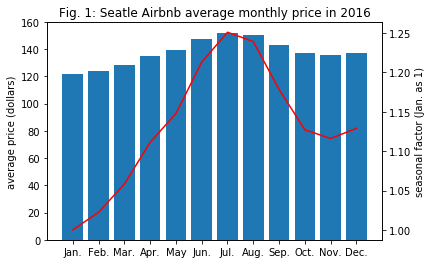

In [43]:
# We plot average price trend and seasonal factor for each month.
fig, ax1 = plt.subplots()
ax2 = plt.twinx()
ax1.bar(price_per_month_2016.month, price_per_month_2016.price)
ax2.plot(price_per_month_2016.month,
         price_per_month_2016.season_factor, c='red')
plt.xticks(ticks=np.arange(1, 13), labels=[
           'Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'Jun.', 'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec.'])
plt.xlabel('month of year')
ax1.set_ylabel('average price (dollars)')
ax2.set_ylabel('seasonal factor (Jan. as 1)')
plt.title('Fig. 1: Seatle Airbnb average monthly price in 2016')
plt.show()

# Save graph as image for later.
fig.savefig('./fig1.png')
plt.close(fig)

Observations:
* 2016 average monthly price is highest in July.
* The price in July is about 1.25 times more expensive compared to lowest price in Januaray.

###### Calendar Data Preparation Summary:
Now we can partly answer to the first business question.<br>
Q1: What are the busiest times of the year to visit Seattle? By how much do prices spike?<br>

Ans.1 (temp):
* From 2016 montly price trend, busiest time can be estimated to be middle of summer, i.e. from July to August. (We will double confirm it with reviews data analysis.) 
* Price peak month is July when price is 1.25 times more expensive compared to lowest price in January.

#### 2-2. Reviews Data Preparation
Let's check data understanding conclusion and import data.

###### Reviews Data Understanding Summary:
* This data is collecting reviews over five years period. We can get review count trend in timeline as well as reviewed listing count trend.
* 'date' column is in string type and we might need format conversion later.
* Only 'comments' column has a few NaN.

In [44]:
reviews_df = pd.read_csv('./reviews.csv')
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


ToDo:
* We convert 'date' column into pandas datetime format for convenience. Then, we extract 'year' and 'month' into new columns.
* Then, we make monthly review count trend through all years.
* We also make yearly unique listing count trend.
<br>

* We convert 'date' column into pandas datetime format for convenience. Then, we extract 'year' and 'month' into new columns.

In [45]:
# We convert date column from string to pandas datetime format.
reviews_df['date'] = pd.to_datetime(reviews_df['date'])

# Then extract year and month information into new columns.
reviews_df['year'] = reviews_df['date'].dt.year
reviews_df['month'] = reviews_df['date'].dt.month

In [46]:
# Checking distribution. -> Seems OK.
reviews_df.describe()

,listing_id,id,reviewer_id,year,month
count,8.484900e+04,8.484900e+04,8.484900e+04,84849.000000,84849.000000
mean,3.005067e+06,3.058765e+07,1.701301e+07,2014.409575,7.454419
std,2.472877e+06,1.636613e+07,1.353704e+07,0.935417,2.828069
min,4.291000e+03,3.721000e+03,1.500000e+01,2009.000000,1.000000
25%,7.946330e+05,1.725127e+07,5.053141e+06,2014.000000,6.000000
50%,2.488228e+06,3.228809e+07,1.413476e+07,2015.000000,8.000000
75%,4.694479e+06,4.457648e+07,2.762402e+07,2015.000000,10.000000
max,1.024814e+07,5.873651e+07,5.281274e+07,2016.000000,12.000000


In [47]:
# 'date' column was not included above, but if we separately try for the column, it works.
reviews_df['date'].describe()

count                   84849
unique                   1930
top       2015-09-21 00:00:00
freq                      580
first     2009-06-07 00:00:00
last      2016-01-03 00:00:00
Name: date, dtype: object

The last date is Jan. 3rd 2016, and so 2016 data is from only a few days.<br>
We should drop 2016 part from montly or yearly analysis.

In [48]:
# We exclude a few days data of 2016.
reviews_df_wo_2016 = reviews_df.query('year != 2016')

* Then, we make monthly review count trend through all years.

In [49]:
# Group by year and month for reviewer_id count
reviews_per_month = reviews_df_wo_2016.groupby(['year', 'month'])[
    'reviewer_id'].count()

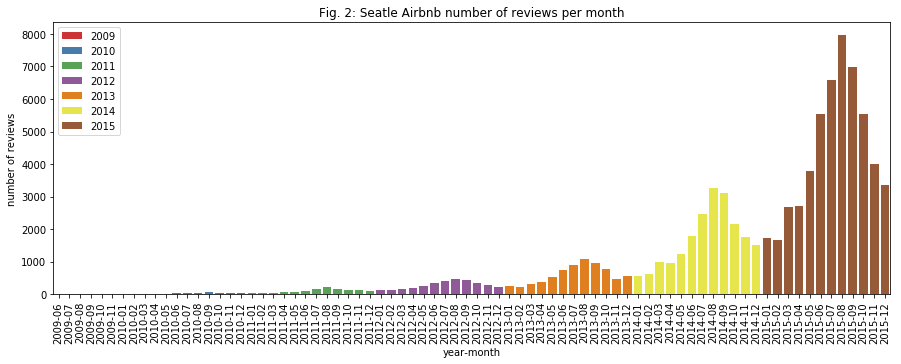

In [50]:
# We plot monthly review count trend through multiple years.
fig = plt.figure(figsize=(15, 5))
sns.barplot(reviews_per_month.index, reviews_per_month.values,
            hue=reviews_per_month.index.get_level_values(0), dodge=False, palette='Set1')
plt.legend(loc='upper left')
plt.xticks(ticks=range(reviews_per_month.shape[0]), labels=[
           '{}-{:02}'.format(y, m) for (y, m) in reviews_per_month.index.values], rotation=90)
plt.xlabel('year-month')
plt.ylabel('number of reviews')
plt.title('Fig. 2: Seatle Airbnb number of reviews per month')
plt.show()

# Save graph as image for later.
fig.savefig('./fig2.png')
plt.close(fig)

Observations:
* Number of reviews are exponentially increasing from 2009 to 2015.<br>
* Peak of montly review count is in August. But as reviews are considered to be posted after check-out time, businest time could be ealier. Anyway combined with price peak time we found earlier, we could say busiest time is middle of summer, i.e. July-August time.

* We also make yearly unique listing count trend.

In [51]:
# Group by year for unique listings count
listings_per_year = reviews_df_wo_2016.groupby(
    ['year'])['listing_id'].nunique()

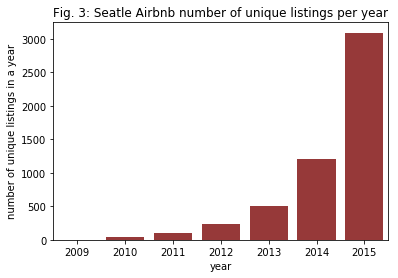

In [52]:
# We plot yearly unique listings count trend through multiple years.
fig = plt.figure()
sns.barplot(listings_per_year.index, listings_per_year.values, color='brown')
plt.xlabel('year')
plt.ylabel('number of unique listings in a year')
plt.title('Fig. 3: Seatle Airbnb number of unique listings per year')
plt.show()

# Save graph as image for later.
fig.savefig('./fig3_.png')
plt.close(fig)

Observations:
* Number of unique listings per year is exponentially increasing from 2009 to 2015.<br>

###### Reviews Data Preparation Summary:
Now we can complete answers to first two question.<br>
Q1: What are the busiest times of the year to visit Seattle? By how much do prices spike?<br>
Q2: Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?<br>

Ans.1 (updated):
* From 2016 montly price trend (fig.1) and 2009-2015 review posts trend (fig.2), busiest time can be estimated to be middle of summer, i.e. from July to August.
* Price peak month is July when price is 1.25 times more expensive compared to lowest price in January (2016).

Ans.2:
* Both number of visitor and number of listings are exponentially increaing from 2009 to 2015.

#### 2-3. Listings Data Preparation
Let's check data understanding summary and import data.<br>
Also let's import listings column type dictionary we saved in data understanding step.

###### Listing Data Understanding Summary:
* Listings data is a spapshot of listings information as of Jan. 2016.
* Listing data columns have been categorized into following lists:
     * dropping_cols
     * id_cols
     * url_cols
     * text_cols
     * date_cols
     * location_cols
     * cat_cols
     * num_cols
     * percent_cols
     * encoded_cols
     * currency_cols
* Some 'reviews' related columns have same NaN distribution pattern.
* 'last_scraped' column have all same date. But together with other date columns, we can calculate some durations.
* Date columns will need format conversion later.
* Free text and URL columns could be converted into size information or binary flags whether information is available.
* There are some host location and listing location columns, which we will have to check redundancies and duplicates.
* There are some columns with % mark. They will have to be changed to numeric.
* Encoded columns with special encoding: 'host_verifications', 'amenities', and 'calendar_updated'
* There are some currency columns that we have to remove '$' and ',' marks.
* We will use 'price' column as a target of prediction model.


In [53]:
listings_df = pd.read_csv('./listings.csv')
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [54]:
# Loading column type dictionary
with open('listings_cols_dict.pickle', 'rb') as f:
    listings_cols_dict = pickle.load(f)

In [55]:
listings_cols_dict.keys()

dict_keys(['dropping_cols', 'id_cols', 'url_cols', 'text_cols', 'date_cols', 'location_cols', 'cat_cols', 'num_cols', 'percent_cols', 'encoded_cols', 'currency_cols'])

ToDo:
* Restore original column type lists
* Replace date columns into duration untill 'last_scraped' date.
* Some 'reviews' related columns have same NaN distribution pattern. Analyse it more and drop or impute data as necessary.
* Converted free text columns and URL columns into either size information or binary flags for information is availability.
* Check location columns for redundancies and duplicates.
* Convert % columns into numeric.
* Convert currency columns with '$' and ',' into numeric.
* Check distribution of numeric columns overall for NaN and outliers.
* Decode special columns: 'host_verifications', 'amenities', and 'calendar_updated'.
* Dummy encode categorical columns.
* Drop all dropping columns.
* Drop all id columns except 'id' column. Make 'id' colum into index.
* Save processed dataframe into a file for modeling step.
<br>

* Restore original column type lists

In [56]:
# Making column type lists in original names
for key, value in listings_cols_dict.items():
    vars()[key] = value

* Replace date columns into duration untill 'last_scraped' date.

In [57]:
# Date columns into pandas datetime format.
for col in date_cols:
    listings_df[col] = pd.to_datetime(listings_df[col])

listings_df[date_cols].describe()

,last_scraped,host_since,calendar_last_scraped,first_review,last_review
count,3818,3816,3818,3191,3191
unique,1,1380,1,984,321
top,2016-01-04 00:00:00,2013-08-30 00:00:00,2016-01-04 00:00:00,2015-09-21 00:00:00,2016-01-02 00:00:00
freq,3818,51,3818,25,94
first,2016-01-04 00:00:00,2008-11-10 00:00:00,2016-01-04 00:00:00,2009-06-07 00:00:00,2011-09-17 00:00:00
last,2016-01-04 00:00:00,2016-01-03 00:00:00,2016-01-04 00:00:00,2016-01-03 00:00:00,2016-01-03 00:00:00


* 'last_scraped' and 'calendar_last_scraped' columns are constant. So they will be moved to 'dropping_cols' list.
* Making 'last_scaped' date as end point, converting the rest of three dates into period till the 'last_scraped' date. 

In [58]:
# Moving two constant columns into 'dropping_cols' list.
dropping_cols += ['last_scraped', 'calendar_last_scraped']
date_cols.remove('last_scraped')
date_cols.remove('calendar_last_scraped')
date_cols

['host_since', 'first_review', 'last_review']

In [59]:
# Converting date_cols into duration till 'last_scraped' date.
for col in date_cols:
    listings_df[col] = listings_df['last_scraped'] - listings_df[col]
    listings_df[col] = listings_df[col].dt.components.days

In [60]:
# Checking distribution -> Seems OK.
listings_df[date_cols].describe()

,host_since,first_review,last_review
count,3816.000000,3191.000000,3191.000000
mean,837.273585,407.743027,74.533375
std,569.795123,402.669792,112.619230
min,1.000000,1.000000,1.000000
25%,355.000000,134.000000,15.000000
50%,752.500000,232.000000,40.000000
75%,1235.000000,553.500000,99.000000
max,2611.000000,2402.000000,1570.000000


* Some 'reviews' related columns have same NaN distribution pattern. Analyse it more and drop or impute data as necessary.

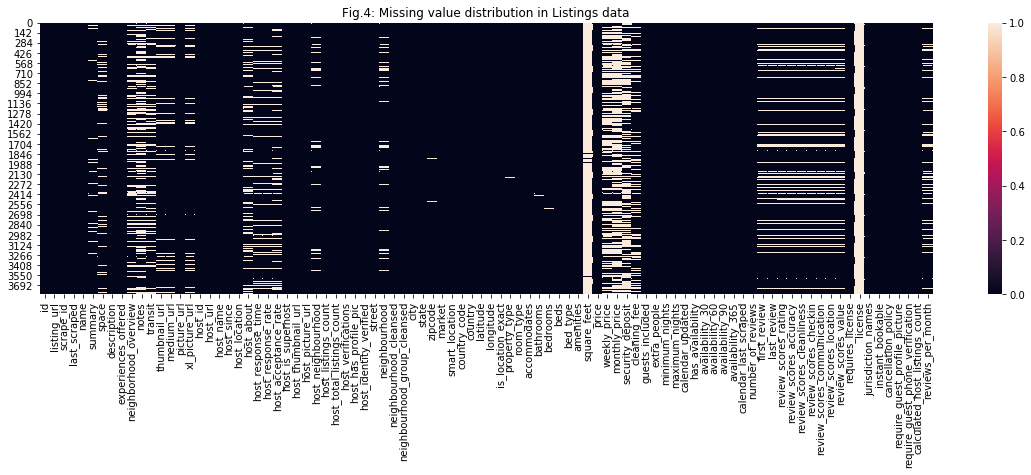

In [61]:
# In order to study 'reviews' related columns, we visualize NaN distribution again.
fig = plt.figure(figsize=(20, 5))
sns.heatmap(listings_df.isnull(), xticklabels=listings_df.columns)
plt.title('Fig.4: Missing value distribution in Listings data')
plt.show()

# Save graph as image for later.
fig.savefig('./fig4.png', bbox_inches='tight')
plt.close(fig)

In [30]:
# Collect 'review' including columns
review_cols = []
for col in listings_df.columns.values:
    if 'review' in col:
        review_cols.append(col)

review_cols

['number_of_reviews',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

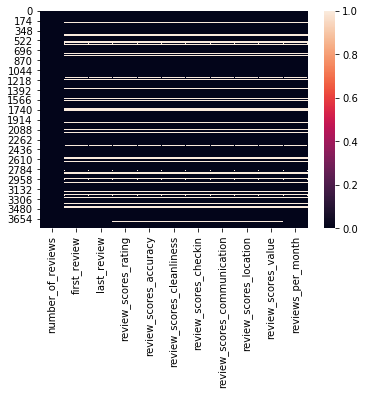

In [31]:
# Visualize NaN distribution
sns.heatmap(listings_df[review_cols].isnull())
plt.show()

Possible hypothesis is that these NaN appear when 'number_of_review' is 0. Let's confirm.

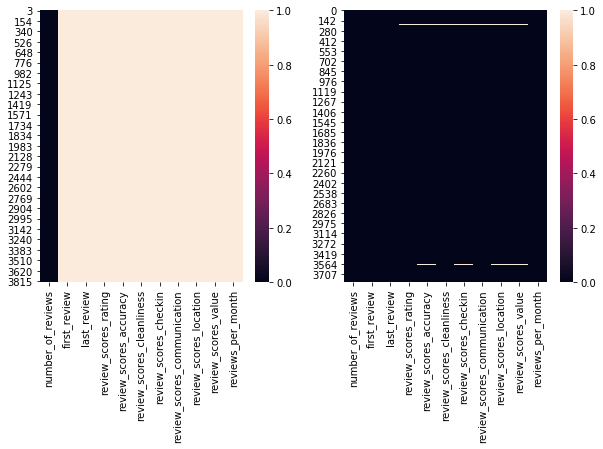

In [32]:
# Checking NaN distributions bunder condition of 'number_of_reviews' == 0 as well as > 0
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = ax
sns.heatmap(listings_df[review_cols]
            [listings_df['number_of_reviews'] == 0].isnull(), ax=ax1)
sns.heatmap(listings_df[review_cols]
            [listings_df['number_of_reviews'] > 0].isnull(), ax=ax2)
plt.show()

Except a few exceptions, above hypothesis seems reasonable.<br>
* For 'reviews_per_month', 'first_review', 'last_review' columns, we fill NaN with zero because they have actually no review yet.
* For review score columns, such as 'review_score_rating', filling NaN with zero might be unfair to new players. So we will fill NaN with mean values. But on the other hand, we will add a binary flag whether review is available to see review impact.

In [33]:
# For following three columns, NaN is filled with zero.
cols_to_fill = ['reviews_per_month', 'first_review', 'last_review']
listings_df[cols_to_fill] = listings_df[cols_to_fill].fillna(0.0)

In [34]:
# Checking distcols_to_fillribution. Seems OK.
listings_df[cols_to_fill].describe()

,reviews_per_month,first_review,last_review
count,3818.000000,3818.000000,3818.000000
mean,1.737514,340.782609,62.293347
std,1.835425,397.911361,106.594434
min,0.000000,0.000000,0.000000
25%,0.310000,69.000000,5.000000
50%,1.105000,188.500000,29.000000
75%,2.660000,510.750000,90.000000
max,12.150000,2402.000000,1570.000000


In [35]:
# For review score columns, one binary flag is added to show whether scores are available.
# 'reviews_score_rating' is referred for all seven score columns.
listings_df['has_review_scores'] = listings_df['review_scores_rating'].notnull(
).astype(int)

# update review cols list
review_cols.append('has_review_scores')

In [36]:
# Original score columns are imputed with mean.
for col in review_cols:
    if 'review_scores_' in col:  # filering review score columns
        listings_df[col].fillna(listings_df[col].mean(), inplace=True)

In [37]:
listings_df[review_cols].describe()

,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,has_review_scores
count,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,22.223415,340.782609,62.293347,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,1.737514,0.830540
std,37.730892,397.911361,106.594434,6.020223,0.635022,0.725880,0.541745,0.517493,0.572542,0.682751,1.835425,0.375207
min,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,0.000000,0.000000
25%,2.000000,69.000000,5.000000,94.000000,9.636392,9.000000,9.786709,9.809599,9.000000,9.000000,0.310000,1.000000
50%,9.000000,188.500000,29.000000,95.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.452245,1.105000,1.000000
75%,26.000000,510.750000,90.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.660000,1.000000
max,474.000000,2402.000000,1570.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,12.150000,1.000000


* Converted free text columns and URL columns into either size information or binary flags for information is availability.

In [38]:
# Extracting text length of free text columns
temp = pd.DataFrame()
for col in text_cols:
    temp[col] = listings_df[col].apply(
        lambda x: len(x) if type(x) == str else x)

In [39]:
# Checking distribution
temp.describe()

,name,summary,space,description,neighborhood_overview,notes,transit,host_name,host_about
count,3818.000000,3641.000000,3249.000000,3818.000000,2786.000000,2212.000000,2884.000000,3816.000000,2959.000000
mean,30.490309,232.926119,614.212373,870.035097,393.479899,281.210669,282.966713,6.358491,459.171004
std,5.152232,62.698369,346.131403,265.654235,271.719201,242.950412,233.160285,3.255707,437.963584
min,7.000000,5.000000,7.000000,11.000000,2.000000,1.000000,1.000000,1.000000,3.000000
25%,28.000000,220.000000,281.000000,995.250000,192.000000,113.000000,122.000000,5.000000,173.000000
50%,32.000000,243.000000,624.000000,1000.000000,312.000000,203.000000,213.500000,6.000000,357.000000
75%,34.000000,249.000000,1000.000000,1000.000000,527.000000,356.000000,359.000000,7.000000,605.500000
max,36.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,28.000000,4354.000000


* Longer description does not necessarily be better for listing value, but we try using text length this time.
* Still 'name' and 'host_name' are irrelevant as prediction features. They will be moved to 'dropping_cols' list.

In [40]:
# First move 'name' and 'host_name' into dropping list.
dropping_cols += ['name', 'host_name']
text_cols.remove('name')
text_cols.remove('host_name')

In [41]:
# Convert text columns into lenght of them. NaN will be replaced with zero.
for col in text_cols:
    listings_df[col] = listings_df[col].apply(
        lambda x: len(x) if type(x) == str else 0)

In [42]:
# Checking distribution. Seems OK.
listings_df[text_cols].describe()

,summary,space,description,neighborhood_overview,notes,transit,host_about
count,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,222.127816,522.675746,870.035097,287.122839,162.922472,213.744369,355.863541
std,78.409356,387.045012,265.654235,290.542828,231.229479,236.349239,430.602572
min,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000
25%,213.000000,165.250000,995.250000,0.000000,0.000000,12.000000,46.000000
50%,242.000000,464.500000,1000.000000,224.000000,74.000000,150.000000,240.000000
75%,249.000000,1000.000000,1000.000000,424.000000,233.000000,299.000000,523.000000
max,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,4354.000000


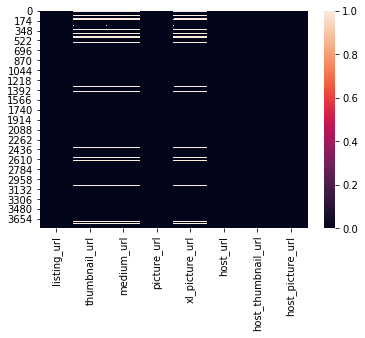

In [43]:
# Next, checking URL columns NaN distribution
sns.heatmap(listings_df[url_cols].isnull())
plt.show()

Three of URL columns have same NaN distribution. So one binary column for three of them will be created for extra URL availability.<br>
Others are all or almost filled and no differentiation is possible. Thus, they are moved to 'dropping_cols' list.

In [44]:
# 'thumbnail_url' column is used as a representative of three extra URL columns.
listings_df['has_extra_urls'] = listings_df['thumbnail_url'].notnull().astype(int)

In [45]:
# Checking newly created column -> Seems OK.
listings_df['has_extra_urls'].describe()

count    3818.000000
mean        0.916186
std         0.277144
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: has_extra_urls, dtype: float64

In [46]:
# All url columns are moved to dropping list.
dropping_cols += url_cols

# URL columns list is replaced with newly created column alone
url_cols = ['has_extra_urls']

* Check location columns for redundancies and duplicates.

In [47]:
listings_df[location_cols].describe()

,host_location,host_neighbourhood,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,jurisdiction_names
count,3810,3518,3818,3402,3818,3818,3818,3818,3811,3818,3818,3818,3818,3818
unique,120,102,1442,81,87,17,7,2,28,1,7,1,1,1
top,"Seattle, Washington, United States",Capitol Hill,"1st Avenue, Seattle, WA 98101, United States",Capitol Hill,Broadway,Other neighborhoods,Seattle,WA,98122,Seattle,"Seattle, WA",US,United States,WASHINGTON
freq,3259,405,30,351,397,794,3810,3817,420,3818,3810,3818,3818,3818


Location columns with too many variety will make too manay variables by dummy encoding.<br>
* We use 'neighbourhood_group_cleansed' for its reasonable number of variety, i.e. 17. We move it into categorical columns list.
* We compare 'host_neighbourhood' and 'neighbourhood' columns whether both are same, and output into a new column for result.
* All other location columns are moved to dropping list.

In [48]:
# We move 'neighbourhood_group_cleanesed' to categorical columns list.
cat_cols.append('neighbourhood_group_cleansed')

In [49]:
# Compare 'host_neightbourhood' and 'neighbourhood' and output the result into 'host_in_same_neighbourhood' column
listings_df['host_in_same_neighbourhood'] = (
    listings_df['host_neighbourhood'] == listings_df['neighbourhood']).astype(int)

listings_df['host_in_same_neighbourhood'].describe()

count    3818.000000
mean        0.805395
std         0.395948
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: host_in_same_neighbourhood, dtype: float64

In [50]:
# Excluide 'neighbourhood_group_cleansed' from location columns list temporaly and add the list into dropping list.
location_cols.remove('neighbourhood_group_cleansed')
dropping_cols += location_cols

In [51]:
# Update location columns list
location_cols = ['host_in_same_neighbourhood']

* Convert % columns into numeric.

In [52]:
# Removing % mark in the end and converting to float.
for col in percent_cols:
    listings_df[col] = listings_df[col].apply(
        lambda x: float(x[:-1]) if type(x) == str else x)

# Checking distributions.
listings_df[percent_cols].describe()

,host_response_rate,host_acceptance_rate
count,3295.000000,3045.000000
mean,94.886798,99.967159
std,11.866705,1.812201
min,17.000000,0.000000
25%,98.000000,100.000000
50%,100.000000,100.000000
75%,100.000000,100.000000
max,100.000000,100.000000


In [53]:
# Checking value counts of 'host_acceptance_rate'
listings_df['host_acceptance_rate'].value_counts()

100.0    3044
0.0         1
Name: host_acceptance_rate, dtype: int64

All except one has 100.0 acceptance. 0.0 might be an error.<br>
But before deciding what to do, we also check NaN counts.

In [54]:
listings_df[percent_cols].isnull().sum()

host_response_rate      523
host_acceptance_rate    773
dtype: int64

* 'host_responce_rate' are all 100.0 except one 0.0 which is probably an error or the listings is closed. We will drop the zero value row, first.
* And there are some NaN. So we create a binary flag to show responce rate availability and drop original column.<br>
* For 'host_acceptance_rate', we will full NaN with mean value.

In [55]:
# For 'host_response_rate' column, first we drop one unusual value row.
listings_df.drop(
    axis=0, index=listings_df[listings_df['host_response_rate'] == 0.0].index, inplace=True)

# Then, we create a binary column to show its availability.
listings_df['has_host_response_rate'] = listings_df['host_response_rate'].notnull(
).astype(int)

# Then, original column is moved to dropping list.
dropping_cols += ['host_response_rate']

In [56]:
# For 'host_acceptance_rate' column, NaN is filled mean value.
listings_df['host_acceptance_rate'].fillna(
    listings_df['host_acceptance_rate'].mean(), inplace=True)

In [57]:
# update percent columns
percent_cols = ['has_host_response_rate', 'host_acceptance_rate']

In [58]:
listings_df[percent_cols].describe()

,has_host_response_rate,host_acceptance_rate
count,3818.000000,3818.000000
mean,0.863017,99.967159
std,0.343874,1.618332
min,0.000000,0.000000
25%,1.000000,100.000000
50%,1.000000,100.000000
75%,1.000000,100.000000
max,1.000000,100.000000


* Convert currency columns with '$' and ',' into numeric.

In [59]:
# For following columns, remove $ marks and ',' marks.
for col in currency_cols:
    listings_df[col] = listings_df[col].apply(
        lambda x: locale.atof(x[1:]) if type(x) == str else x)

In [60]:
listings_df[currency_cols].describe()

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
count,3818.000000,2009.000000,1517.000000,1866.000000,2788.000000,3818.000000
mean,127.976166,788.481832,2613.336190,287.610397,61.710904,10.667627
std,90.250022,532.352269,1722.267981,270.222690,48.830341,17.585922
min,20.000000,100.000000,500.000000,95.000000,5.000000,0.000000
25%,75.000000,455.000000,1512.000000,150.000000,25.000000,0.000000
50%,100.000000,650.000000,2200.000000,250.000000,50.000000,0.000000
75%,150.000000,950.000000,3150.000000,300.000000,83.000000,20.000000
max,1000.000000,6300.000000,19500.000000,5000.000000,300.000000,300.000000


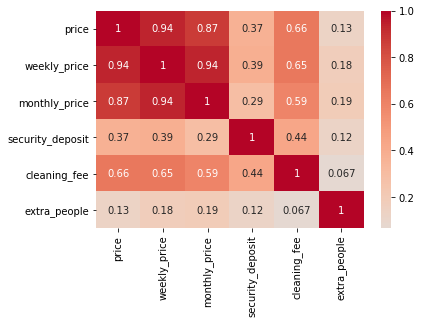

In [61]:
# As we use 'price' column for prediction target, we should check correlations with other prices.
sns.heatmap(listings_df[currency_cols].corr(),
            annot=True, cmap='coolwarm', center=0.0)
plt.show()


* Naturally 'weekly_price' and 'monthly_price' have strong correlations with 'price'. We should drop it from predition features.
* 'cleaning_fee' also shows 0.66 correlation. We should drop it as well.
* 'security_deposit' is difficult to decide. But we will drop it, just in case, this time.
* 'extra_people' could be kept.
* For dropping prices, we will add binary columns to show price availabilities.

In [62]:
# columns to be replaced with binary flags.
replacing_cols = ['weekly_price', 'monthly_price',
                  'cleaning_fee', 'security_deposit']

# Adding 'has_' columns to show information availabilities.
for col in replacing_cols:
    listings_df['has_' + col] = listings_df[col].notnull().astype(int)

In [63]:
# Moving original columns into dropping list
dropping_cols += replacing_cols

In [64]:
# Checking distribution of newly added columns.-> Seems OK.
listings_df[['has_' + col for col in replacing_cols]].describe()

,has_weekly_price,has_monthly_price,has_cleaning_fee,has_security_deposit
count,3818.000000,3818.000000,3818.000000,3818.000000
mean,0.526192,0.397328,0.730225,0.488738
std,0.499379,0.489409,0.443901,0.499939
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


* Check distribution of numeric columns overall for NaN and outliers.

In [65]:
# Checking num_cols distribution, first 15 columns.
listings_df[num_cols[:15]].describe()

,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365
count,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656
std,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526
min,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000
50%,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000
75%,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000
max,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000


In [66]:
# Checking the rest of columns.
listings_df[num_cols[15:]].describe()

,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,2.946307,1.737514
std,37.730892,6.020223,0.635022,0.725880,0.541745,0.517493,0.572542,0.682751,5.893029,1.835425
min,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,1.000000,0.000000
25%,2.000000,94.000000,9.636392,9.000000,9.786709,9.809599,9.000000,9.000000,1.000000,0.310000
50%,9.000000,95.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.452245,1.000000,1.105000
75%,26.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,2.660000
max,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,37.000000,12.150000


* Small number of Nan in 'host_listings_count', 'host_total_listings_count', 'bathrooms', 'bedrooms', 'beds'.
* Outliers should be further checked for 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count', 'minimum_nights', 'maximum_nights'.
* What is different among 'host_listings_count', 'host_total_listings_count', and 'calculated_host_listings_count'? We will check it first.

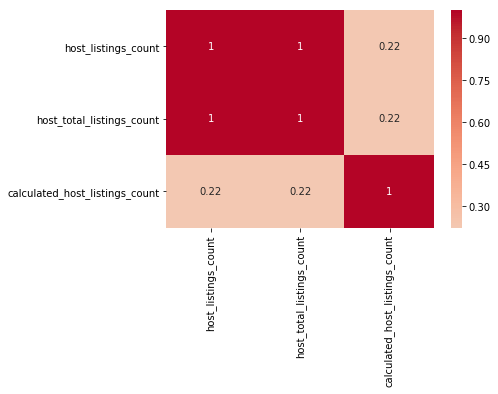

In [67]:
# Checking correlations among three host listing count columns.
sns.heatmap(listings_df[['host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count']].corr(),
            annot=True, cmap='coolwarm', center=0.0)
plt.show()

The first two are 1.0 correlation. We can drop one of them.

In [68]:
# moving 'host_listings_count' to dropping list
dropping_cols += ['host_listings_count']
num_cols.remove('host_listings_count')

In [69]:
# Confirming NaN counts (except 'host_listings_count' to be dropped)
listings_df[['host_total_listings_count',
             'bathrooms', 'bedrooms', 'beds']].isnull().sum()

host_total_listings_count     2
bathrooms                    16
bedrooms                      6
beds                          1
dtype: int64

In [70]:
# We drop these few NaN in row
listings_df.dropna(axis=0, subset=num_cols, inplace=True)

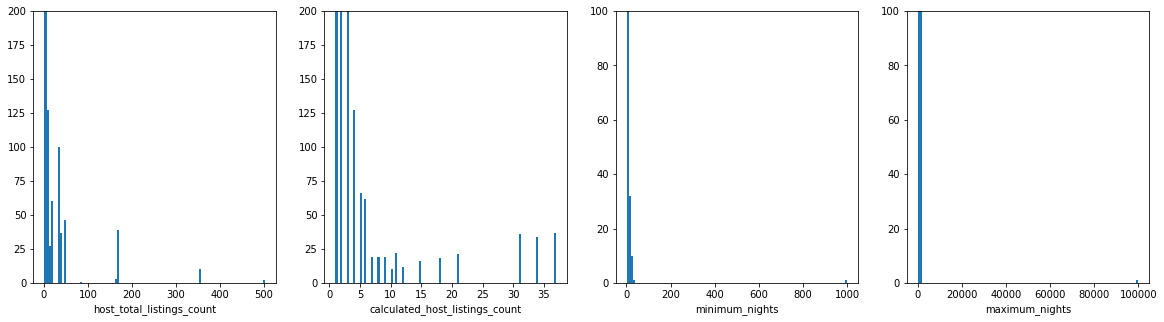

In [71]:
# checking distribution for suspected columns (except 'host_listings_count' to be dropped)
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax1, ax2, ax3, ax4 = ax
ax1.hist(listings_df['host_total_listings_count'], bins=100)
ax1.set_xlabel('host_total_listings_count')
ax1.set_ylim(top=200)
ax2.hist(listings_df['calculated_host_listings_count'], bins=100)
ax2.set_xlabel('calculated_host_listings_count')
ax2.set_ylim(top=200)
ax3.hist(listings_df['minimum_nights'], bins=100)
ax3.set_xlabel('minimum_nights')
ax3.set_ylim(top=100)
ax4.hist(listings_df['maximum_nights'], bins=100)
ax4.set_xlabel('maximum_nights')
ax4.set_ylim(top=100)
plt.show()

* 'host_total_listings_count': Distribution is sparse on higher values, but we will keep it as it is.
* 'calculated_host_total_listings_count': Same above
* 'minimum_nights' : Near 1000 minimum nights is outlier. We will drop it.
* 'maximum_nights': Near 100000 maximum nights is outlier. But there might be other outliers. We magnitude x-axis as follows.

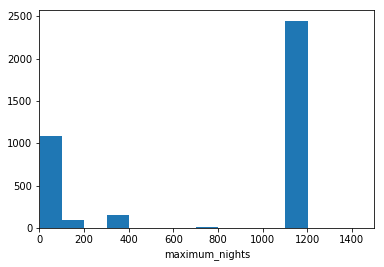

In [72]:
# Display 'maximum_nights' distribution, adjusting x/y axis range.
plt.hist(listings_df['maximum_nights'], bins=1000)  # increased bins
plt.xlabel('maximum_nights')
plt.xlim(left=0, right=1500)  # set range limit for x-axis
plt.show()

'maximum_nights' still has unnatural peak near 1100. It might be due to some system restriction and it might actually means 'No imint'.<br>
So instead of keep it as numeric, we make it categorical as follows.
* nights <= a week
* a week < nights <= a month
* a month < nights <= 3 months
* 3 months < nights <= 6 months
* 6 months < nights <= 1 year
* 1 year < nights <= 3 years
* 3 years < nights

But first, we drop 'mininum_nights' outlier before we forget.

In [73]:
# Dropping min nights outliers
min_night_outliers = listings_df.query('minimum_nights > 365')
listings_df.drop(axis=0, index=min_night_outliers.index, inplace=True)

In [74]:
# define a special function for maximum_nights conversiont to categories
def cat_days_period(nights):
    '''
    args: nights (int) - number of days to be converted
    returns: categorized period (str) - 7 different range of periods
    '''
    if nights <= 7:
        return 'max_nighits_le7d'
    elif nights <= 31:
        return 'max_nights_mt7d_le1m'
    elif nights <= 3 * 31:
        return 'max_nights_mt1m_le3m'
    elif nights <= 6 * 31:
        return 'max_nights_mt3m_le6m'
    elif nights <= 365:
        return 'max_nights_mt6m_le1y'
    elif nights <= 3 * 365:
        return 'max_nigths_mt1y_le3y'
    else:
        return 'max_nights_mt3y'


# apply the function to 'maximum_nights' column
listings_df['maximum_nights'] = listings_df['maximum_nights'].apply(
    cat_days_period)

# Move 'maximum_nights' to categorical columns list.
cat_cols += ['maximum_nights']
num_cols.remove('maximum_nights')

* Decode special columns: 'host_verifications', 'amenities', and 'calendar_updated'.

In [75]:
listings_df[encoded_cols].head()

,host_verifications,amenities,calendar_updated
0,"['email', 'phone', 'reviews', 'kba']","{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4 weeks ago
1,"['email', 'phone', 'facebook', 'linkedin', 're...","{TV,Internet,""Wireless Internet"",Kitchen,""Free...",today
2,"['email', 'phone', 'google', 'reviews', 'jumio']","{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",5 weeks ago
3,"['email', 'phone', 'facebook', 'reviews', 'jum...","{Internet,""Wireless Internet"",Kitchen,""Indoor ...",6 months ago
4,"['email', 'phone', 'facebook', 'reviews', 'kba']","{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",7 weeks ago


In [76]:
# First making a whole set of verification methods.
methods_list = list()
for methods in listings_df['host_verifications'].unique():
    methods_list += re.findall(r"\'(\w+)\'", methods)
    methods_list = list(set(methods_list))

# Create new columns for each method and initialize with zero.
for method in methods_list:
    listings_df.loc[:, method] = 0.0

In [77]:
# Checking original column and decode the result into above created columns.
for index, value in listings_df['host_verifications'].iteritems():
    methods = re.findall(r"\'(\w+)\'", value)
    listings_df.loc[index, methods] = 1.0

listings_df.drop(['host_verifications'], axis=1, inplace=True)

In [78]:
listings_df[methods_list].describe()

,reviews,google,facebook,manual_offline,kba,email,weibo,linkedin,manual_online,jumio,amex,phone,photographer,sent_id
count,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000
mean,0.929871,0.196151,0.504350,0.013709,0.475613,0.971263,0.001318,0.234115,0.003427,0.337991,0.006591,0.993409,0.001055,0.002373
std,0.255398,0.397136,0.500047,0.116297,0.499471,0.167089,0.036288,0.423501,0.058451,0.473088,0.080928,0.080928,0.032461,0.048660
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [79]:
# First making a whole set of amenities.
amenities_list = list()
for amenities in listings_df['amenities'].unique():
    amenities_list += re.findall(r"\{([^\{\}\'\"\,]+)\,", amenities)
    amenities_list += re.findall(r"\,([^\{\}\'\"\,]+)\}", amenities)
    amenities_list += re.findall(r"\,([^\{\}\'\"\,]+)\,", amenities)
    amenities_list += re.findall(r"\"([^\{\}\'\"\,]+)\"", amenities)
    amenities_list = list(set(amenities_list))

# Create new columns for each amenity and initialize with zero.
for amenity in amenities_list:
    listings_df.loc[:, amenity] = 0.0

In [80]:
# Checking original column and decode the result into above created columns.
for index, value in listings_df['amenities'].iteritems():
    amenities_list = re.findall(r"\{([^\{\}\'\"\,]+)\,", value)
    amenities_list += re.findall(r"\,([^\{\}\'\"\,]+)\}", value)
    amenities_list += re.findall(r"\,([^\{\}\'\"\,]+)\,", value)
    amenities_list += re.findall(r"\"([^\{\}\'\"\,]+)\"", value)
    listings_df.loc[index, amenities_list] = 1.0

listings_df.drop(['amenities'], axis=1, inplace=True)

In [81]:
listings_df[amenities_list].describe()

,TV,Internet,Kitchen,Dog(s),Heating,Washer,Essentials,Hangers,Cable TV,Wireless Internet,Free Parking on Premises,Pets live on this property,Elevator in Building,Hot Tub,Indoor Fireplace,Buzzer/Wireless Intercom,Family/Kid Friendly,Smoke Detector,Laptop Friendly Workspace
count,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000
mean,0.674137,0.736884,0.854732,0.132613,0.714210,0.545215,0.827841,0.211178,0.377274,0.961508,0.568152,0.231479,0.204324,0.079357,0.233061,0.140786,0.514632,0.861851,0.195887
std,0.468758,0.440383,0.352417,0.339200,0.451849,0.498017,0.377569,0.408199,0.484768,0.192406,0.495399,0.421833,0.403260,0.270330,0.422836,0.347846,0.499852,0.345102,0.396934
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [82]:
listings_df['calendar_updated'].value_counts()

today            701
2 weeks ago      343
3 weeks ago      300
2 months ago     276
a week ago       247
yesterday        229
3 months ago     214
4 weeks ago      213
3 days ago       162
5 weeks ago      156
4 days ago       145
4 months ago     133
5 days ago       131
6 weeks ago      118
2 days ago        96
5 months ago      90
7 weeks ago       63
6 days ago        28
6 months ago      27
1 week ago        26
never             24
7 months ago      23
8 months ago      14
10 months ago      8
9 months ago       7
12 months ago      5
11 months ago      5
22 months ago      2
13 months ago      2
14 months ago      1
16 months ago      1
30 months ago      1
15 months ago      1
17 months ago      1
Name: calendar_updated, dtype: int64

Let's first try converting it to numeric.

In [83]:
# Decode 'calendar_updated' column with dedicated decoder function.
def decode_calendar_updated(value):
    '''
    args: value (str) - original string from 'calendar_updated' column
    returns: days (int) - decoded integer in days
    '''
    if 'today' in value:
        return 0
    elif 'yesterday' in value:
        return 1
    elif 'never' in value:
        return 365 * 7  # about 7 years
    elif 'day' in value:
        return int(re.findall(r"^(\d+) \D+", value)[0])
    elif 'a week' in value:
        return 7
    elif 'week' in value:
        return 7 * int(re.findall(r"^(\d+) \D+", value)[0])
    elif 'month' in value:
        return 31 * int(re.findall(r"^(\d+) \D+", value)[0])
    else:
        return value


listings_df['calendar_updated'] = listings_df['calendar_updated'].apply(
    decode_calendar_updated)

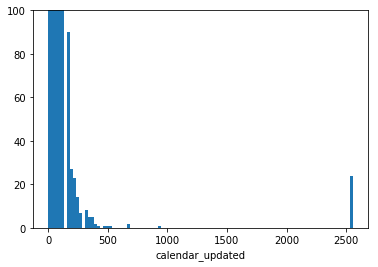

In [84]:
# Checking distribution
plt.hist(listings_df['calendar_updated'], bins=100)
plt.xlabel('calendar_updated')
plt.ylim(top=100)
plt.show()

Those over 2500 outliers are original 'never'.<br>
We experienced similar unnatural outliers in 'maxmum_nights' column earler.<br>
And we use the same function to catetorize this column, too

In [85]:
listings_df['calendar_updated'] = listings_df['calendar_updated'].apply(
    cat_days_period)

In [86]:
# Move 'calendar_updated' to categorical columns list
cat_cols += ['calendar_updated']

* Dummy encode all categorical columns.

In [87]:
listings_df = pd.get_dummies(
    listings_df, dummy_na=True, columns=cat_cols, drop_first=True)

* Drop all dropping columns.

In [88]:
listings_df.drop(dropping_cols, axis=1, inplace=True)

In [89]:
# Checking overall NaN count left.
listings_df.isnull().sum().sum()

0

* Drop all id columns except 'id'. Make 'id' colum into index.

In [90]:
id_cols

['id', 'scrape_id', 'host_id']

In [91]:
# first, make 'id' column into index.
listings_df.set_index('id', inplace=True)

In [92]:
# drop id_cols (except 'id' as index)
listings_df.drop(id_cols[1:], axis=1, inplace=True)
listings_df.head()

,summary,space,description,neighborhood_overview,notes,transit,host_since,host_about,host_acceptance_rate,host_total_listings_count,...,maximum_nights_max_nights_mt7d_le1m,maximum_nights_max_nigths_mt1y_le3y,maximum_nights_nan,calendar_updated_max_nights_mt1m_le3m,calendar_updated_max_nights_mt3m_le6m,calendar_updated_max_nights_mt3y,calendar_updated_max_nights_mt6m_le1y,calendar_updated_max_nights_mt7d_le1m,calendar_updated_max_nigths_mt1y_le3y,calendar_updated_nan
id,,,,,,,,,,,,,,,,,,,,,
241032,0,1000,1000,0,0,0,1607.0,372,100.000000,3.0,...,0,0,0,0,0,0,0,1,0,0
953595,249,1000,1000,167,1000,162,1047.0,74,100.000000,6.0,...,0,0,0,0,0,0,0,0,0,0
3308979,241,1000,1000,669,155,202,571.0,343,100.000000,2.0,...,1,0,0,1,0,0,0,0,0,0
7421966,243,0,243,0,0,0,789.0,0,99.967159,1.0,...,0,0,0,0,1,0,0,0,0,0
278830,184,488,1000,492,9,295,1497.0,354,99.967159,2.0,...,0,0,0,1,0,0,0,0,0,0


* Save processed dataframe into a file for modeling step.

In [93]:
listings_df.to_pickle('./listings_df.pickle')